# Support Vector Machines on Banknote Authentication (Linear vs RBF)
**Student:** Yarra Ashok (ID: 24091071)

Goal: build intuition for SVM margins and kernels, then prove value with clean experiments:
- Linear SVM vs RBF SVM (kernel trick).
- Proper scaling, stratified split, and cross-validated hyperparameter tuning.
- Hard results: ROC-AUC, PR-AUC, confusion matrices, and calibration.

Dataset: UCI Banknote Authentication (four wavelet features, binary labels).  
Source: UCI ML Repository: https://archive.ics.uci.edu/dataset/267/banknote+authentication


Github Link:https://github.com/ashok-yarra/ML-Assignment.git

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import (
    accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score,
    confusion_matrix, ConfusionMatrixDisplay, classification_report, brier_score_loss
)
from sklearn.calibration import CalibratedClassifierCV

RANDOM_STATE = 24091071  # fixed for reproducibility
np.random.seed(RANDOM_STATE)

plt.rcParams["figure.figsize"] = (6,5)
plt.rcParams["axes.grid"] = True
plt.rcParams["font.size"] = 11


## 1. Load the dataset

Features (all numeric): variance, skewness, curtosis, entropy.  
Target: `class` (0 = genuine, 1 = forged).


In [ ]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt"
cols = ["variance", "skewness", "curtosis", "entropy", "class"]
df = pd.read_csv(url, header=None, names=cols)

print(df.shape)
df.head()


(1372, 5)


,variance,skewness,curtosis,entropy,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


In [ ]:
display(df.describe().T)
df['class'].value_counts().rename({0:"genuine", 1:"forged"})


,count,mean,std,min,25%,50%,75%,max
variance,1372.0,0.433735,2.842763,-7.0421,-1.773000,0.49618,2.821475,6.8248
skewness,1372.0,1.922353,5.869047,-13.7731,-1.708200,2.31965,6.814625,12.9516
curtosis,1372.0,1.397627,4.310030,-5.2861,-1.574975,0.61663,3.179250,17.9274
entropy,1372.0,-1.191657,2.101013,-8.5482,-2.413450,-0.58665,0.394810,2.4495
class,1372.0,0.444606,0.497103,0.0000,0.000000,0.00000,1.000000,1.0000


class
genuine    762
forged     610
Name: count, dtype: int64

## 2. Train/test split (stratified) and scaling in a pipeline

SVMs are sensitive to feature scales, so we’ll **always** scale inside the pipeline.


In [ ]:
X = df.drop(columns=['class'])
y = df['class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

X_train.shape, X_test.shape, y_train.mean(), y_test.mean()


((1097, 4), (275, 4), 0.4448495897903373, 0.44363636363636366)

## 3. Baseline: Linear SVM (hinge loss) vs RBF SVM (kernel trick)

- **Linear SVM** finds a maximum-margin hyperplane.  
- **RBF SVM** maps to a high-dimensional space implicitly; `gamma` controls locality, `C` controls margin softness.


In [ ]:
# LinearSVC doesn't provide probabilities → wrap with calibration for ROC/PR.
lin_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("lin_svc", LinearSVC(C=1.0, random_state=RANDOM_STATE))
])

cal_lin = CalibratedClassifierCV(lin_pipe, method="sigmoid", cv=5)
cal_lin.fit(X_train, y_train)

y_pred_lin = cal_lin.predict(X_test)
y_proba_lin = cal_lin.predict_proba(X_test)[:,1]

lin_acc = accuracy_score(y_test, y_pred_lin)
lin_auc = roc_auc_score(y_test, y_proba_lin)
lin_ap = average_precision_score(y_test, y_proba_lin)

lin_acc, lin_auc, lin_ap


(0.9818181818181818, 0.9996249866066645, 0.9995414788513678)

In [ ]:
rbf_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC(kernel="rbf", C=1.0, gamma="scale", probability=True, random_state=RANDOM_STATE))
])

rbf_pipe.fit(X_train, y_train)
y_pred_rbf = rbf_pipe.predict(X_test)
y_proba_rbf = rbf_pipe.predict_proba(X_test)[:,1]

rbf_acc = accuracy_score(y_test, y_pred_rbf)
rbf_auc = roc_auc_score(y_test, y_proba_rbf)
rbf_ap = average_precision_score(y_test, y_proba_rbf)

rbf_acc, rbf_auc, rbf_ap


(1.0, 1.0, 1.0)

## 4. Cross-validated hyperparameter tuning (RBF)

We search a small, sensible grid for `C` (margin softness) and `gamma` (kernel width).  
K-fold is stratified; scoring uses ROC-AUC for ranking.


In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

grid = {
    "svc__C": [0.1, 1, 3, 10, 30, 100],
    "svc__gamma": ["scale", 0.1, 0.03, 0.01, 0.003, 0.001]
}

gs = GridSearchCV(
    Pipeline([("scaler", StandardScaler()), ("svc", SVC(kernel="rbf", probability=True))]),
    param_grid=grid, cv=cv, scoring="roc_auc", n_jobs=-1, refit=True
)
gs.fit(X_train, y_train)

gs.best_params_, gs.best_score_


({'svc__C': 0.1, 'svc__gamma': 'scale'}, 1.0)

In [ ]:
best_rbf = gs.best_estimator_
y_pred_best = best_rbf.predict(X_test)
y_proba_best = best_rbf.predict_proba(X_test)[:,1]

best_acc = accuracy_score(y_test, y_pred_best)
best_auc = roc_auc_score(y_test, y_proba_best)
best_ap  = average_precision_score(y_test, y_proba_best)

print("Best RBF (test) — ACC:", round(best_acc, 4), "ROC-AUC:", round(best_auc, 4), "PR-AUC:", round(best_ap, 4))
print(gs.best_params_)
print("\nClassification report:\n", classification_report(y_test, y_pred_best, digits=3))


Best RBF (test) — ACC: 0.9927 ROC-AUC: 1.0 PR-AUC: 1.0
{'svc__C': 0.1, 'svc__gamma': 'scale'}

Classification report:
               precision    recall  f1-score   support

           0      1.000     0.987     0.993       153
           1      0.984     1.000     0.992       122

    accuracy                          0.993       275
   macro avg      0.992     0.993     0.993       275
weighted avg      0.993     0.993     0.993       275



## 5. Confusion matrices (Linear vs tuned RBF)


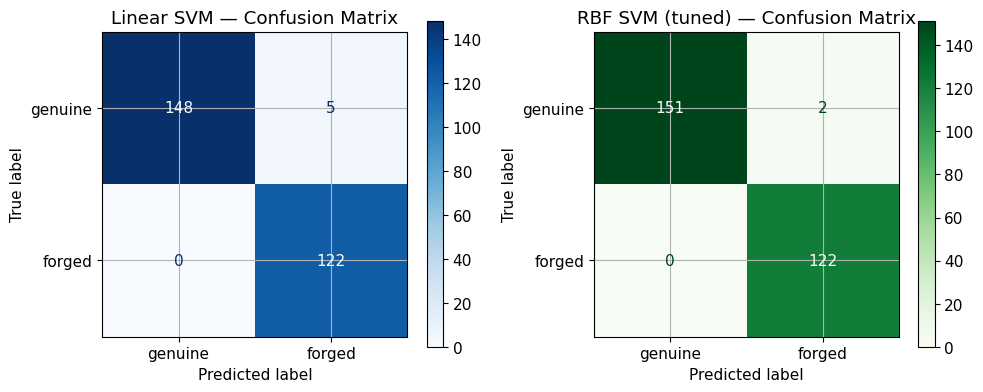

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))

cm_lin = confusion_matrix(y_test, y_pred_lin, labels=[0,1])
ConfusionMatrixDisplay(cm_lin, display_labels=["genuine","forged"]).plot(ax=axes[0], cmap="Blues", values_format="d")
axes[0].set_title("Linear SVM — Confusion Matrix")

cm_best = confusion_matrix(y_test, y_pred_best, labels=[0,1])
ConfusionMatrixDisplay(cm_best, display_labels=["genuine","forged"]).plot(ax=axes[1], cmap="Greens", values_format="d")
axes[1].set_title("RBF SVM (tuned) — Confusion Matrix")

plt.tight_layout(); plt.show()


## 6. ROC and Precision-Recall curves (Linear vs tuned RBF)

These show threshold-independent quality. PR-AUC is especially informative if class imbalance is present.


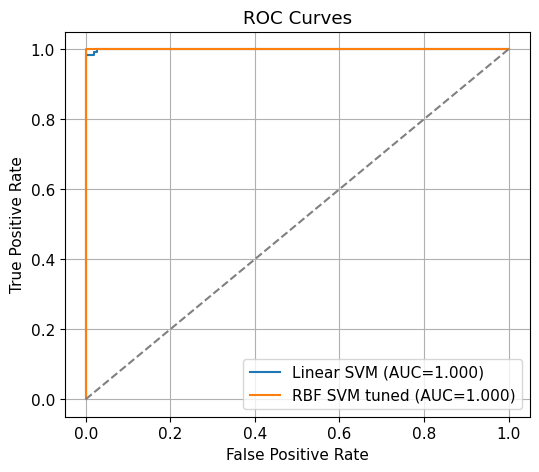

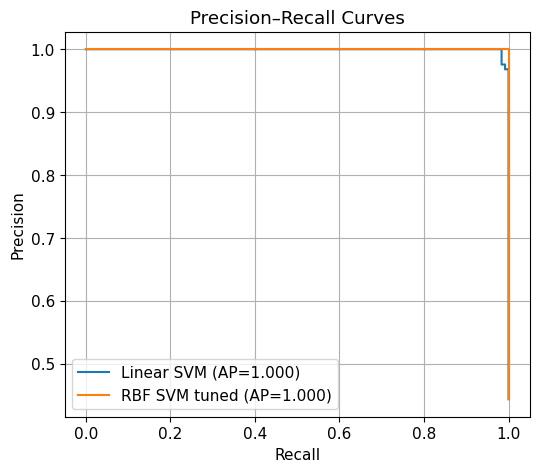

In [ ]:
# ROC
fpr_lin, tpr_lin, _ = roc_curve(y_test, y_proba_lin)
fpr_best, tpr_best, _ = roc_curve(y_test, y_proba_best)

plt.plot(fpr_lin, tpr_lin, label=f"Linear SVM (AUC={roc_auc_score(y_test, y_proba_lin):.3f})")
plt.plot(fpr_best, tpr_best, label=f"RBF SVM tuned (AUC={roc_auc_score(y_test, y_proba_best):.3f})")
plt.plot([0,1],[0,1],"--", color="grey")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curves"); plt.legend(); plt.grid(True); plt.show()

# PR
prec_lin, rec_lin, _ = precision_recall_curve(y_test, y_proba_lin)
prec_best, rec_best, _ = precision_recall_curve(y_test, y_proba_best)

plt.plot(rec_lin, prec_lin, label=f"Linear SVM (AP={average_precision_score(y_test, y_proba_lin):.3f})")
plt.plot(rec_best, prec_best, label=f"RBF SVM tuned (AP={average_precision_score(y_test, y_proba_best):.3f})")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision–Recall Curves"); plt.legend(); plt.grid(True); plt.show()


## 7. Calibration check (optional but valuable)

SVM probabilities are post-processed; we’ll verify with Brier Score (lower is better) and a quick reliability curve via bins.


Brier — Linear: 0.0114
Brier — RBF tuned: 0.0013


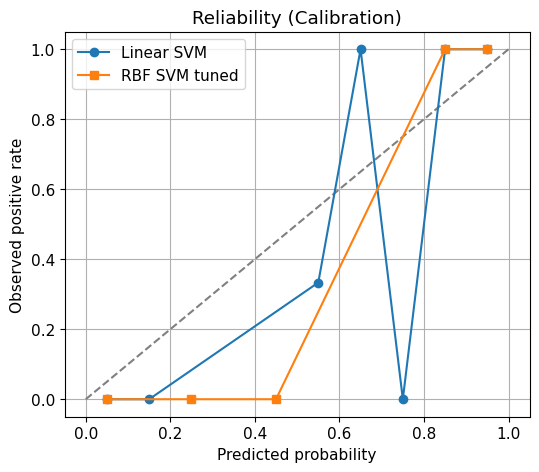

In [ ]:
def brier(y_true, y_prob):
    return brier_score_loss(y_true, y_prob)

print("Brier — Linear:", round(brier(y_test, y_proba_lin), 4))
print("Brier — RBF tuned:", round(brier(y_test, y_proba_best), 4))

# Reliability curve (10 bins)
bins = np.linspace(0,1,11)
def reliability(y_true, y_prob, bins):
    ix = np.digitize(y_prob, bins) - 1
    bin_centers, prob_true = [], []
    for b in range(len(bins)-1):
        mask = ix == b
        if mask.sum() == 0:
            continue
        bin_centers.append((bins[b]+bins[b+1])/2)
        prob_true.append(y_true[mask].mean())
    return np.array(bin_centers), np.array(prob_true)

c_lin_x, c_lin_y = reliability(y_test.values, y_proba_lin, bins)
c_best_x, c_best_y = reliability(y_test.values, y_proba_best, bins)

plt.plot([0,1],[0,1],"--", color="grey")
plt.plot(c_lin_x, c_lin_y, marker="o", label="Linear SVM")
plt.plot(c_best_x, c_best_y, marker="s", label="RBF SVM tuned")
plt.xlabel("Predicted probability"); plt.ylabel("Observed positive rate")
plt.title("Reliability (Calibration)"); plt.legend(); plt.grid(True); plt.show()


## 8. Two-feature decision boundary (didactic view)

Project to two informative features for a visual boundary: variance vs skewness.


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


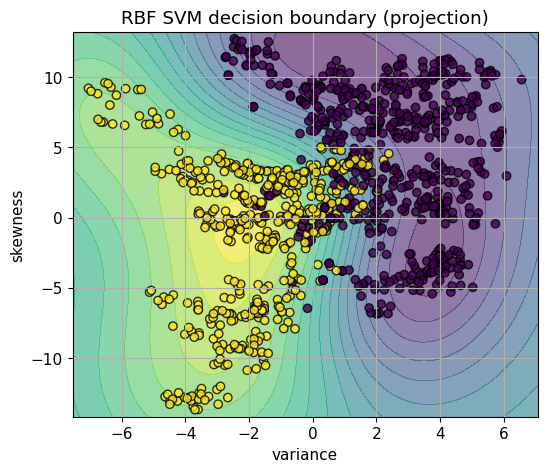

In [ ]:
feat = ["variance","skewness"]
X2 = X_train[feat].copy()
x_min, x_max = X2[feat[0]].min()-0.5, X2[feat[0]].max()+0.5
y_min, y_max = X2[feat[1]].min()-0.5, X2[feat[1]].max()+0.5

grid_x, grid_y = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))
grid = np.c_[grid_x.ravel(), grid_y.ravel()]

pipe2 = Pipeline([("scaler", StandardScaler()), ("svc", SVC(kernel="rbf", C=gs.best_params_["svc__C"], gamma=gs.best_params_["svc__gamma"]))])
pipe2.fit(X2, y_train)

Z = pipe2.decision_function(grid).reshape(grid_x.shape)

plt.contourf(grid_x, grid_y, Z, levels=20, alpha=0.6)
scatter = plt.scatter(X2[feat[0]], X2[feat[1]], c=y_train, edgecolor="k", alpha=0.8)
plt.xlabel(feat[0]); plt.ylabel(feat[1])
plt.title("RBF SVM decision boundary (projection)")
plt.show()


## 9. Summary

- Scaling is non-negotiable for SVMs.  
- Linear SVM is a strong baseline; RBF SVM dominates when the boundary is non-linear.  
- `C` (margin softness) and `gamma` (kernel width) must be tuned with stratified CV.  
- Report both threshold-independent (ROC-AUC/PR-AUC) and threshold-dependent (confusion matrix) metrics.  
- If deployment needs probabilities, verify **calibration**.
